In [1]:
import pandas as pd
import numpy as  np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import random
from sklearn.model_selection import train_test_split
from google.colab import files
#tf.compat.v1.enable_eager_execution()
import datetime
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 10)

/home/anany/anaconda3/envs/ML/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


In [2]:
#files.upload()
data=pd.read_csv("Design1a_Para2_S21.csv")
data
data_points_initially = data.shape[1]-1

In [3]:
def clean_data(data):
    data=data.replace([-np.inf], np.nan)
    data=data.dropna(axis=1, how='all')
    data.isnull().to_numpy().any()
    return data

In [4]:
def input_parameters(data):
    output=np.empty((0,4), float)
    for columns in data.columns[1:]:
        params=columns.split(' ')[3:]
        param=[]
        for vals in params:
            param.append(float(vals.split('=')[1][1:-3]))
        param=np.array([param])
        output=np.concatenate((output, param), axis=0)
    return output

In [5]:
data = clean_data(data)
X = input_parameters(data)
data

,Freq [GHz],"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='1mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='2mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='3mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='4mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='5mm' s2='0.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='2mm' g2='0mm' s1='1mm' s2='1mm'",...,"dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='4mm' s2='1.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='5mm' s2='1.5mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='1mm' s2='2mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='2mm' s2='2mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='3mm' s2='2mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='4mm' s2='2mm'","dB(S(FloquetPort2:1,FloquetPort1:1)) [] - g1='10mm' g2='2mm' s1='5mm' s2='2mm'"
0,1.0,-26.899047,-21.738253,-18.556836,-16.289351,-14.415687,-28.692293,...,-1.162021,-1.399727,-0.773223,-1.028858,-1.145530,-1.295512,-1.712422
1,1.1,-26.068833,-20.907403,-17.723808,-15.450868,-13.571228,-27.861928,...,-1.481307,-1.801839,-0.956926,-1.278987,-1.436946,-1.641933,-2.179723
2,1.2,-25.310477,-20.148358,-16.962408,-14.683555,-12.797495,-27.103407,...,-1.868085,-2.297861,-1.167445,-1.568240,-1.779575,-2.057079,-2.744214
3,1.3,-24.612427,-19.449567,-16.261093,-13.975885,-12.083003,-26.405176,...,-2.337269,-2.911946,-1.407813,-1.901746,-2.181853,-2.554778,-3.427390
4,1.4,-23.965701,-18.802051,-15.610893,-13.318908,-11.418845,-25.758255,...,-2.908003,-3.676443,-1.681577,-2.285596,-2.654119,-3.152574,-4.257601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,19.6,-0.321875,-1.548532,-7.952840,-21.568599,-18.472182,-0.438480,...,-14.145785,-4.052525,-0.339645,-1.882012,-0.990868,-0.939139,-0.074768
187,19.7,-0.293934,-1.631440,-8.234867,-17.505902,-14.123273,-0.407896,...,-20.280597,-1.298253,-0.379687,-12.386174,-0.785210,-1.664051,-0.079466
188,19.8,-0.266269,-1.725217,-8.533635,-13.911005,-5.799198,-0.378492,...,-3.103160,-0.278496,-0.561133,-0.383659,-1.398534,-3.167465,-0.270965
189,19.9,-0.239161,-1.830872,-8.848792,-10.397368,-16.825132,-0.350309,...,-8.823352,-0.063454,-0.564289,-0.237429,-2.228234,-21.069916,-0.604613


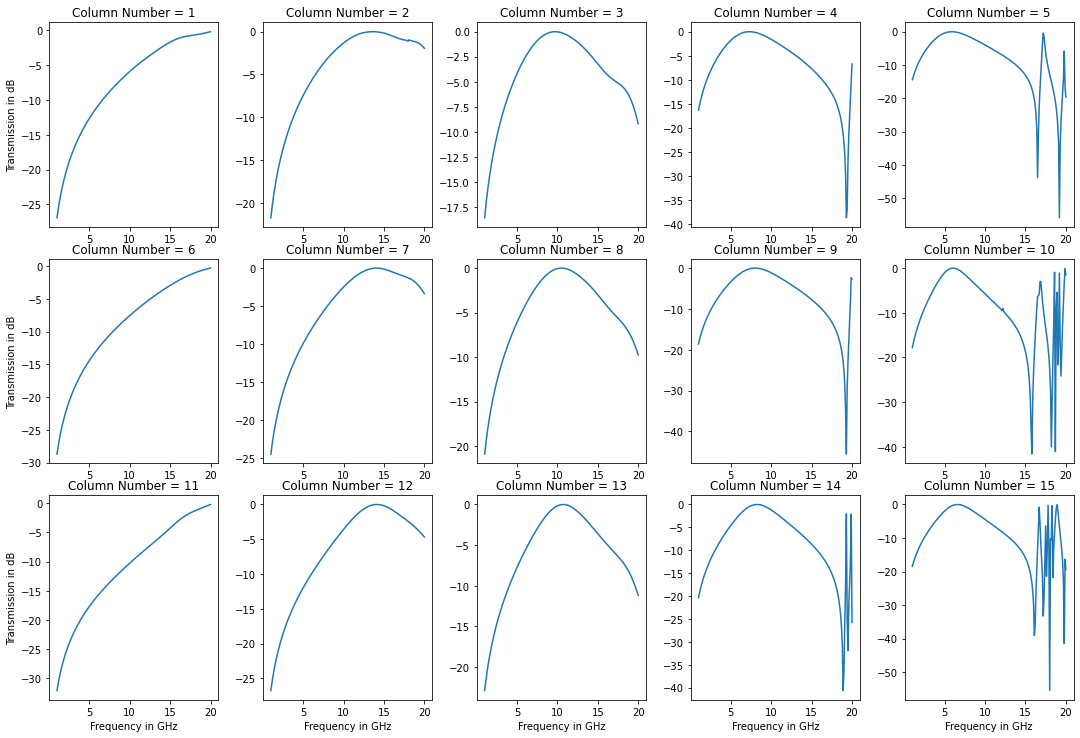

In [6]:
rows=3
columns=5
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        index=1+x*columns+y
        window[x][y].title.set_text("Column Number = %d" % index)
        window[x][y].plot(data.iloc[:, 0], data.iloc[:, index])
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

points with no apparent first cutoff = 137


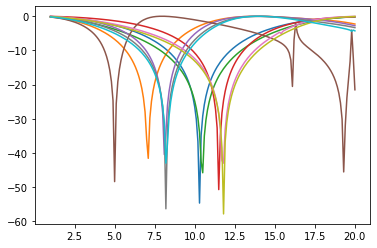

In [7]:
no_first_cutoff = 0
r1 = -0.25
r = -0.45
plot = 10
for index in range(1, data.shape[1]):
  if data.iloc[0, index] > r1 and min(data.iloc[:, index]) < r:
    no_first_cutoff = no_first_cutoff + 1
    if plot > 0 and min(data.iloc[:, index]) < -40:
      plot = plot - 1
      plt.plot(data.iloc[:, 0], data.iloc[:, index])
print('points with no apparent first cutoff = %d' % no_first_cutoff)

In [8]:
trans_cutoff = -0.45
output_data = np.empty((0,2),float)
index_range = np.empty((0,2), int)
indices = []
input_data = np.empty((0,4), float)
ignore_subsequent_cutoffs = True
for column in range(1, data.shape[1]):
  cutoff_index_curr = []
  first_cutoff_found = False
  for index in range(1, data.shape[0]):
    prev = data.iloc[index-1,column]
    curr = data.iloc[index,column]
    if prev < trans_cutoff and curr >= trans_cutoff \
    and not first_cutoff_found:
      cutoff_index_curr.append(index)
      first_cutoff_found = True
    if prev >= trans_cutoff and curr < trans_cutoff \
    and first_cutoff_found:
      cutoff_index_curr.append(index-1)
      first_cutoff_found = False
  if len(cutoff_index_curr) <= 1:
    continue
  elif len(cutoff_index_curr) % 2 != 0:
    cutoff_index_curr = cutoff_index_curr[0:-1]
  #print(cutoff_index_curr)
  cutoff_index_curr = np.array(cutoff_index_curr)
  cutoff_index_curr = cutoff_index_curr.reshape(-1, 2)
  if ignore_subsequent_cutoffs:
    cutoff_index_curr = cutoff_index_curr[0:1]
  for cutoff in cutoff_index_curr:
      indices.append(column)
      input_data = np.concatenate((input_data, X[column-1:column]))
      op_curr = np.array([data.iloc[cutoff, 0].to_numpy()])
      output_data = np.concatenate((output_data, op_curr))
  index_range= np.concatenate((index_range, cutoff_index_curr))
# print(output_data)
# print(index_range)
# print(input_data)
# print(indices)
print('''Total data points = %d
Useful data points = %d
Loss in data points = %d'''
%(data_points_initially, len(indices),
data_points_initially-1-len(indices)))

Total data points = 600
Useful data points = 484
Loss in data points = 115


In [10]:
use_old_method_of_data_cleaning = False
if use_old_method_of_data_cleaning:
  output_data = np.empty((0,2),float)
  index_range = np.empty((0,2), int)
  indices = []
  input_data = np.empty((0,4), float)
  r = -0.45
  r1 = -0.30
  r2 = -0.30
  rmin = -0.10
  for index in range(1, data.shape[1]):
      temp = []
      ix = []
      freq = []
      found = False
      for i, val in enumerate(data.iloc[:, index]):
          if r <= val:
              found = True
              temp.append(val)
              ix.append(i)
              freq.append(data.iloc[i, 0])
              continue
          if found:
              break
      if len(temp) >= 2 and temp[0] < r1 and temp[-1] < r2 and max(temp) > rmin:
          freq = np.array([[freq[0], freq[-1]]])
          ix = np.array(([[ix[0], ix[-1]]]))
          indices.append(index)
          index_range = np.concatenate((index_range, ix))
          output_data = np.concatenate((output_data, freq))
          input_data = np.concatenate((input_data, X[index-1:index]))
  # print(output_data)
  # print(index_range)
  # print(input_data)
  # print(indices)
  print('''Total data points = %d
  Useful data points = %d
  Loss in data points = %d'''
  %(data.shape[1]-1, len(indices),
  data.shape[1]-1-len(indices)))

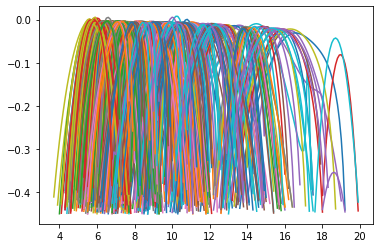

In [11]:
begin = 0
stop = np.inf
for i, index in enumerate(indices):
  if i>=begin and i<=stop:
    start = index_range[i][0]
    end = index_range[i][1]
    plt.plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, index])

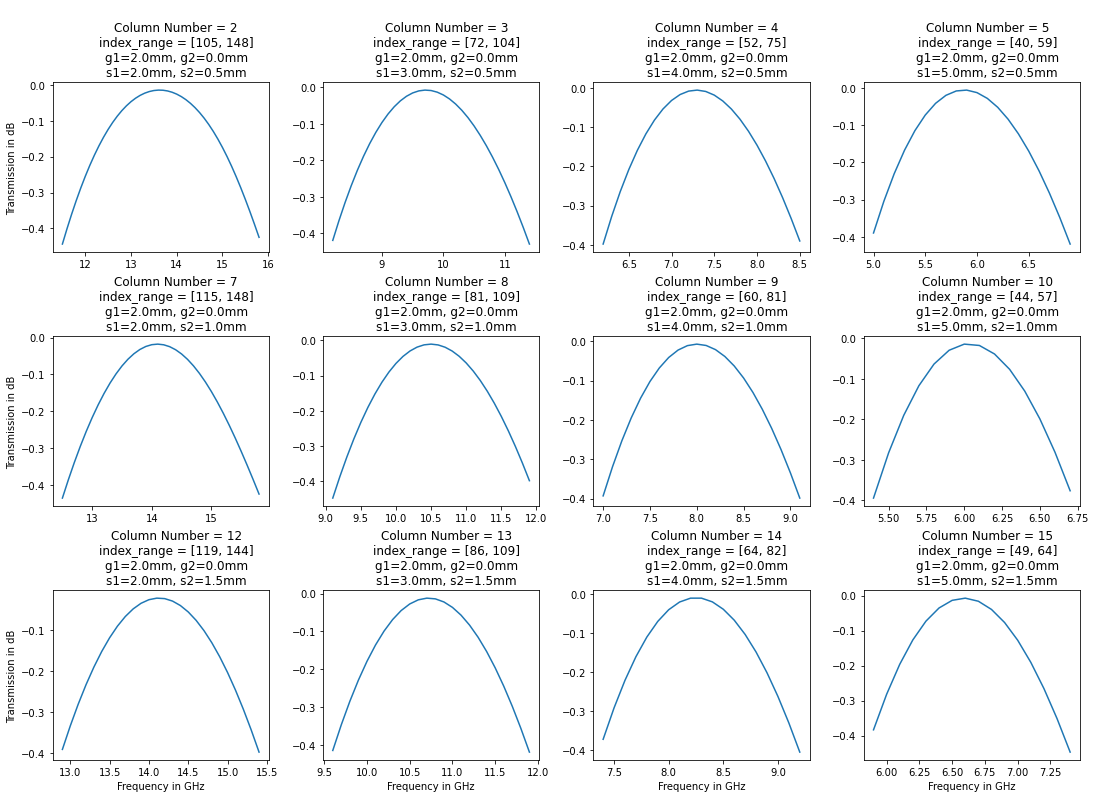

In [12]:
rows = 3
columns = 4
fig, window =  plt.subplots(rows, columns, figsize=(15,10))
fig.tight_layout()
for x in range(0,rows):
    for y in range(0, columns):
        position = x*columns+y
        column_index = indices[position]
        start = index_range[position][0]
        end = index_range[position][1]
        params=input_data[position]
        window[x][y].plot(data.iloc[start:end+1, 0], data.iloc[start:end+1, column_index])
        window[x][y].title.set_text('''
        Column Number = %d
        index_range = [%d, %d]
        g1=%.1fmm, g2=%.1fmm
        s1=%.1fmm, s2=%.1fmm''' 
        % (column_index, start, end, *params))
plt.subplots_adjust(wspace=0.25, hspace=0.5)
plt.setp(window[-1, :], xlabel='Frequency in GHz');
plt.setp(window[:, 0], ylabel='Transmission in dB');

In [13]:
Normalize=True
normalized_output = np.copy(output_data)
if Normalize:
  mean=[]
  sigma=[]
  for column in range(0,2):
    m = np.mean(output_data[:,column])
    s = np.max(output_data[:,column]) - np.min(output_data[:,column])
    mean.append(m)
    sigma.append(s)
    normalized_output[:,column]=(output_data[:,column]-m)/s
normalized_output[0:10,:]

array([[ 0.25873101,  0.40904395],
       [ 0.04582778,  0.07571062],
       [-0.08320448, -0.14398635],
       [-0.16062383, -0.26519847],
       [ 0.32324713,  0.40904395],
       [ 0.1038923 ,  0.11358941],
       [-0.03159158, -0.09853181],
       [-0.13481738, -0.28034999],
       [ 0.34905359,  0.37874092],
       [ 0.13615036,  0.11358941]])

In [14]:
Normalize_input=True
normalized_input = np.copy(input_data)
if Normalize_input:
  input_mean=[]
  input_sigma=[]
  for column in range(0,4):
      m = np.mean(input_data[:,column])
      s = np.max(input_data[:,column]) - np.min(input_data[:,column])
      input_mean.append(m)
      input_sigma.append(s)
      normalized_input[:,column]=(input_data[:,column]-m)/s
normalized_input

array([[-0.4107438 , -0.50619835, -0.27272727, -0.50413223],
       [-0.4107438 , -0.50619835, -0.02272727, -0.50413223],
       [-0.4107438 , -0.50619835,  0.22727273, -0.50413223],
       ...,
       [ 0.3892562 ,  0.49380165, -0.02272727,  0.49586777],
       [ 0.3892562 ,  0.49380165,  0.22727273,  0.49586777],
       [ 0.3892562 ,  0.49380165,  0.47727273,  0.49586777]])

In [15]:
cleaned_data = np.concatenate((input_data, output_data), axis=1)
cleaned_data = pd.DataFrame(cleaned_data, columns=['g1 (mm)', 'g2 (mm)',
                                                   's1 (mm)', 's2 (mm)', 
                                                   'freq1 (GHz)', 'freq2 (GHz)'])
cleaned_data

,g1 (mm),g2 (mm),s1 (mm),s2 (mm),freq1 (GHz),freq2 (GHz)
0,2.0,0.0,2.0,0.5,11.5,15.8
1,2.0,0.0,3.0,0.5,8.2,11.4
2,2.0,0.0,4.0,0.5,6.2,8.5
3,2.0,0.0,5.0,0.5,5.0,6.9
4,2.0,0.0,2.0,1.0,12.5,15.8
...,...,...,...,...,...,...
479,10.0,2.0,1.0,2.0,6.9,8.8
480,10.0,2.0,2.0,2.0,6.3,8.3
481,10.0,2.0,3.0,2.0,5.6,7.7
482,10.0,2.0,4.0,2.0,5.1,7.2


In [16]:
for index in range(0,4):
  print(cleaned_data[cleaned_data.columns[index]].value_counts())

10.0    100
8.0     100
6.0     100
4.0      98
2.0      82
0.0       4
Name: g1 (mm), dtype: int64
2.0    100
1.0     98
1.5     96
0.5     96
0.0     94
Name: g2 (mm), dtype: int64
5.0    103
4.0    100
3.0    100
2.0    100
1.0     81
Name: s1 (mm), dtype: int64
2.0    124
1.5    120
1.0    120
0.5    120
Name: s2 (mm), dtype: int64


In [17]:
def data():
  return train_test_split(normalized_input, normalized_output, test_size=0.20, shuffle=True)
def learn(epochs, seed=0):
  log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  tf.random.set_seed(seed)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(8,input_shape=(4,),activation='relu'))
  model.add(tf.keras.layers.Dense(32,activation='relu'))
  model.add(tf.keras.layers.Dense(2,activation='tanh'))
  model.compile(loss='mse', optimizer='adam')
  history=model.fit(X_train, y_train, validation_split=0.2, epochs=epochs,
                    verbose=0, shuffle=True, callbacks=[tensorboard_callback])
  return model, history

In [18]:
def input(inp, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(inp)
    for column in range(0,4):
      op[:,column] = (inp[:,column]-mean[column])/(sigma[column])
    return op
  return inp
    
def output(prediction, mean, sigma, Normalize):
  if Normalize:
    op=np.copy(prediction[:])
    for column in range(0,2):
          op[:,column] = (prediction[:,column]*sigma[column])+mean[column]
    return op
  return prediction

In [ ]:
acceptable_loss = 0.40
epochs = 350
max_count = 9
initial_seed = random.randint(1,1000)
from sklearn.metrics import mean_squared_error as mse
X_train, X_test, y_train, y_test = data()
model, history = learn(epochs, initial_seed)
prediction = output(model.predict(X_test), mean, sigma, Normalize)
y = output(y_test, mean, sigma, Normalize)
test_loss = mse(prediction, y, squared=False)
min_loss_states=[]
while test_loss >= acceptable_loss and max_count>0:
  print("Test Loss very high, trying again. [test loss = %f]" % test_loss)
  X_train, X_test, y_train, y_test = data()
  ran_val = random.randint(1,1000)
  model, history = learn(epochs, ran_val)
  prediction = output(model.predict(X_test), mean, sigma, Normalize)
  y = output(y_test, mean, sigma, Normalize)
  test_loss = mse(prediction, y, squared=False)
  min_loss_states.append([ran_val, test_loss])
  max_count = max_count - 1
print("test loss c1= %0.1f, precision= %0.1f" % (mse(prediction[:,0], y[:,0], squared=False), 0.1))
print("test loss c2= %0.1f, precision= %0.1f" % (mse(prediction[:,1], y[:,1], squared=False), 0.1))
print("test loss avg= %f" % test_loss)
min_loss_states.sort(key=lambda state: state[1])
print(min_loss_states)

Test Loss very high, trying again. [test loss = 1.222373]


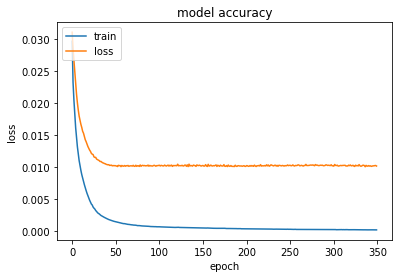

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'loss'], loc='upper left')
plt.show()

In [20]:
inp=input_data[30:40]
normal_input = input(inp, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(normal_input)
result = output(normal_output, mean, sigma, Normalize)
result = result.round(1)
result = np.where(result<=0, 0, result)
print(result)
print(output_data[30:40])

[[11.1 14.3]
 [ 8.5 11.3]
 [ 6.9  9.3]
 [ 5.7  7.5]
 [ 9.9 17. ]
 [ 8.2 14.5]
 [ 6.8 11.9]
 [ 5.6  9.5]
 [ 4.5  7.4]
 [10.5 17. ]]
[[10.9 14.3]
 [ 8.7 11.4]
 [ 7.   9.3]
 [ 5.8  7.7]
 [10.  18.2]
 [ 8.1 14.9]
 [ 6.6 11.9]
 [ 5.4  9.5]
 [ 4.5  7.7]
 [10.8 17.4]]


In [21]:
g1_range = np.arange(0.0, 10.1, 0.25)
g2_range = np.arange(0.0, 2.1, 0.25)
s1_range = np.arange(1.0, 5.1, 0.25)
s2_range = np.arange(0.5, 2.1, 0.25)
combs = np.empty((0,4), dtype=np.float)
for x in g1_range:
  for y in g2_range:
    for z in s1_range:
      for w in s2_range:
        arr = np.array([[x, y, z, w]])
        combs=np.concatenate((combs, arr))
print("total_points = %d" % combs.shape[0])

total_points = 43911


In [22]:
inp = input(combs, input_mean, input_sigma, Normalize_input)
normal_output = model.predict(inp)
frequencies = output(normal_output, mean, sigma, Normalize)
frequencies = frequencies.round(3)
frequencies = np.where(frequencies<=0, 0, frequencies)
frequencies

array([[15.453, 18.492],
       [15.531, 18.546],
       [15.61 , 18.6  ],
       ...,
       [ 4.456,  6.65 ],
       [ 4.525,  6.721],
       [ 4.525,  6.649]], dtype=float32)

In [23]:
def find_best_match(frequencies, sizes, input):
  min_error = 100
  index = -1
  for ind, frequency in enumerate(frequencies):
    error = (abs(frequency[0]-input[0])+abs(frequency[1]-input[1]))/2
    if error < min_error:
      min_error = error
      index = ind
  return sizes[index], min_error

In [24]:
inps = np.array([[2,4],[3,6],[8,10],[2,18],[10,15],[15,19],[18,19],[7,18],[9,16],[11,12],[17,18]], dtype=np.float)
for input in inps:
  op=find_best_match(frequencies, combs,  input)
  print(op[0], 'expected_error = %0.2f'%op[1] )

[10.   2.   5.   0.5] expected_error = 2.09
[10.   2.   5.   0.5] expected_error = 0.59
[3.  1.5 3.5 2. ] expected_error = 0.01
[6.75 0.   1.   0.5 ] expected_error = 4.38
[4.5  0.75 2.   0.75] expected_error = 0.01
[2.   1.75 1.   1.  ] expected_error = 0.01
[0.25 1.75 2.25 1.5 ] expected_error = 0.03
[6.75 0.   1.   0.5 ] expected_error = 1.88
[6.25 0.   1.25 0.5 ] expected_error = 0.02
[1.   0.   4.25 2.  ] expected_error = 0.03
[0.25 2.   2.5  0.75] expected_error = 0.01


In [25]:
 model.save('good.h5')
files.download('good.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>